In [1]:
import collections
import random
from random import  uniform
from math import *
import scipy.optimize as opt
import math 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import warnings
import numpy as np
import multiprocessing
import pickle
from random import randint

multiprocessing.set_start_method('fork')
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Auxiliary Functions

In [2]:
def write_dict(d):
    """
    writes dictionary $d$ to file
    """
    with open('data.pkl', 'wb') as file:
        pickle.dump(d, file)
        
def read_dict():
    """
    returns parsed dictionary from data.pkl
    """
    with open('data.pkl', 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

In [3]:
def Hi(v):
    """
    Inverse of the binary entropy function
    """
    if v==1:
        return 0.5
    if v < 0.000001:
        return 0
    return fsolve(lambda x:v -(-x[0]*log2(x[0])-(1-x[0])*log2(1-x[0])),0.0000001)[0]

def H(c):
    """
    Entropy function
    """
    if c == 0. or c == 1.:
        return 0.
    
    if c < 0. or c > 1.:
        return -1000
    
    return -(c * log2(c) + (1 - c) * log2(1 - c))

def binomH(n,k):
    """
    binomial coefficient
    """
    # if k/n not in ZZ:
    #     return -100
    if(n<=0):
        return 0.
    return n * H(k/n)


# Permutation-based ISD

#### Prange SD

In [1]:
def uniquness_bound(kp):
    """ 
    uniqueness bound for RSD instance for given rate $kp$
    """
    return fsolve(lambda x:log2(1/x[0])*x[0]-(1-kp),0.00001)[0]

def prange(k,w):
    """
    complexity exponent of Prange ISD on SD
    """
    # exploit symmetry in case weight larger than 1/2
    if w>0.5:
        w=1-w
    # polynomial regime
    if w>(1-k)/2 and w<(1+k)/2:
        return 0
    
    # time in case w>n-k, implies there must be p>0
    if w>1-k:
        def time(p):
            return binomH(1,w)-binomH(1-k,w-p)
        return opt.fminbound(time, w-(1-k),w, xtol=1e-10, full_output=1)[1]

    return binomH(1,w)-binomH(1-k,w)

def prange_sd(k,w):
    """
    complexity exponent of Prange ISD on SD taking into account the existence of multiple solutions
    """
    # prange time with speedup in number of solutions
    return max(prange(k,w)-max(binomH(1,w)-(1-k),0),0)

#### Perm (Section 4.1)

In [5]:
def sample_per_block(k,w):
    """
    complexity exponent of PERM
    """
    # time for RSD permutations
    return w*log2(1/(1-k))

def time_perm_rsd(k,w):
    """
    complexity exponent of PERM taking into account the existence of multiple solutions
    """
    # time for updated dimension with linear speedup in number of solutions
    return max(sample_per_block(k-w,w)-max(log2(1/w)*w-(1-k),0),0)

# Optimization Specific Functions

From here on we use numerical optimization programs with multiple optimization parameters.
We therefore specify some additional auxiliary functions

In [6]:
#dimension and weight functions used globally by the optimization programs
k = lambda x : 1
w = lambda x : 1

# block length in k+ell part
v = lambda x : ((k(x)+x.ell)/x.N)

# overall block length
b = lambda x : (1/w(x))

In [7]:
def wrap(f,g) :
    """
    composes to functions f and g
    """
    def inner(x):
        return f(g(*x))
    return inner

def r(x,y,z):
    """
    returns list of length $z$ containing uniform floats in the range (x,y)
    """
    return [(uniform(x,y)) for i in range(z)]

def time_opt(kp,w_in,time,memory,constraints,num_vars,iterations=30,give_x=0, params=0):
    """
    time and constraints define optimization program with goal to minimize time while ensuring all constraints
    memory is function that thakes the optimization parameters returning memory of the algorithm
    num_vars specifies number of optimization parameters
    iterations specify how often optimization is run (best result is returned)
    kp, w_in define dimension and weight (regularity is encoded by the time_opt function)
    """
    
    kp=max(0,kp-w_in)
    
    # sets k, w functions used by time and constraints 
    global k,w
    k = lambda x : kp
    w = lambda x : w_in
    
    # polynomial regime
    if k([])<0:
        return 0
    
    # minimize over multiple runs of the optimizer
    res=1000
    ress=1000
    for j in range(iterations):

        # set random starting points and bounds    
        if randint(0,1)==0:
            start=r(0,0.1,num_vars-1)+r(max(0,w_in-0.1),w_in,1)
        else:
            start=r(0,0.009,num_vars-1)+r(max(0,w_in-0.000001),w_in,1)
        bounds=[(0,1)]*(num_vars-1)+[(0,w_in)]

        # optimize and store minimum
        result = opt.minimize(time, start, 
                bounds= bounds, tol=1e-8, 
                constraints=constraints, options={'maxiter':2000})
        tmp = result.get('fun')
        if(tmp < res and tmp >0 and result.success):
            res = tmp
            ress = result
            
    # return full output (for debugging)
    if give_x:
        return ress

    if type(ress)==int:
        return [1,1,[]]

    #return time and memory
    if params:
        return [res,memory(ress.x),ress.x]
    return [res,memory(ress.x)]

# Enumeration-based ISD (Section 4.2)

In [8]:
# ell, p as in the paper
# N is the number of blocks used to sample from for the k+ell part
set_vars_enum = collections.namedtuple('ENUM', 'ell p N')

def enum(f) : return wrap(f, set_vars_enum)

def time_enum_par(x):
    """
    complexity exponent of ENUM variant for given set of parameters (ell, p, N) 
    """
    x=set_vars_enum(*x)
    
    # some constraints to ensure computations are well defined
    # those are covered (even more strict) in the constraints array, but it is not ensured
    # that the time_enum_par function is only called on parameters satisfying the constraint array
    # while a final solution is of course only valid if the constraint array is fully satisfied
    if(b(x)-v(x))<1e-10:
        return 1000
    if x.p>x.N or v(x)/b(x)<=0 or 1-v(x)/b(x)<=0:
        return 1000
    
    # probability of having x.p blocks out of x.N with weight and x.N-x.p with weight zero
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p
    # list size
    L1=binomH(x.N/2,x.p/2)+log2(v(x))*x.p/2
    # matches
    L = 2*L1 - x.ell
    
    return max(L1,L)-prob

def memory_enum_par(x):
    """
    memory exponent of ENUM variant for given set of parameters (ell, p, N) 
    """
    x=set_vars_enum(*x)
    L1=binomH(x.N/2,x.p/2)+log2(v(x))*x.p/2
    return L1

constraints_enum = [
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : enum(lambda x : 1-(x.ell+k([])))},
    { 'type' : 'ineq',   'fun' : enum(lambda x : w(x)-x.N)},
    
    # to always sample from all blocks comment next line and uncomment the one after
    { 'type' : 'ineq',   'fun' : enum(lambda x : x.N-x.p)},
    #{ 'type' : 'eq',   'fun' : enum(lambda x : x.N-x.p)},
    
    
    # blocks of width at least one
    { 'type' : 'ineq',   'fun' : enum(lambda x : b(x)-v(x)-1)},
    { 'type' : 'ineq',   'fun' : enum(lambda x : v(x)-0.9999)},
      

]

def time_enum(k,w, params=0):
    """
    complexity exponent of ENUM variant minimized over all suitable parameters (ell, p, N) 
    """
    # outputs time and memory to solve RSD via Enum
    return time_opt(k,w,time_enum_par,memory_enum_par,constraints_enum,3,iterations=500,give_x=0, params=params)


# Representation-based ISD

#### Depth 3 (Section 4.3)

In [9]:
set_vars_bj = collections.namedtuple('REP', 'ell p d1 d2 N')

def rep(f) : return wrap(f, set_vars_bj)

def representations(ell,p_target,p_addends,x):
    """
    representations of one v(x)-regular vector of weight p_target and length ell * v(x) 
    as sum of two v(x)-regular vectors of weight p_addend (and length ell * v(x))
    """
    x=set_vars_bj(*x)
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(v(x))*(p_addends-p_target/2)

# weight on each level (root level is level 0 with weight x.p)
p1 = lambda x: x.p/2      + x.d1
p2 = lambda x: p1(x) / 2  + x.d2
p3 = lambda x: p2(x) / 2

# representations ri from level i to level i-1
r1 = lambda x: representations(x.N, x.p  , p1(x), x)
r2 = lambda x: representations(x.N, p1(x), p2(x), x)

# list sizes on each level
L1 = lambda x: binomH(x.N  ,p1(x))+log2(v(x))*p1(x) - r1(x)
L2 = lambda x: binomH(x.N  ,p2(x))+log2(v(x))*p2(x) - r2(x)
L3 = lambda x: binomH(x.N/2,p3(x))+log2(v(x))*p3(x)

# time Ti to construct lists on level i
T1 = lambda x: max(2*L1(x) - ( x.ell - r1(x)), L1(x))
T2 = lambda x: max(2*L2(x) - ( r1(x) - r2(x)), L2(x))
T3 = lambda x: max(2*L3(x) - ( r2(x        )), L3(x))


                      
def time_rep_par(x):
    """
    complexity exponent of REP variant for given set of parameters (ell p d1 d2 N) 
    """
    x=set_vars_bj(*x)  
    
    # ensuring block length on k+ell part is not larger than overall block length
    if v(x)/b(x)>=1:
        return 1000
    
    #probability as in enum
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p

    return max(T1(x),T2(x),T3(x))-prob

def memory_rep_par(x):
    """
    memory exponent of REP variant for given set of parameters (ell p d1 d2 N) 
    """
    x=set_vars_bj(*x)
    return max(L3(x),L2(x),L1(x))

constraints_rep = [
    
    # representation constraints
    { 'type' : 'ineq',   'fun' : rep(lambda x : x.ell-r1(x))},
    { 'type' : 'ineq',   'fun' : rep(lambda x : r1(x)-r2(x))},
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : rep(lambda x : 1-(x.ell+k([])))},
    # for considering always all blocks in the permutation switch next both lines
    #{ 'type' : 'ineq',   'fun' : rep(lambda x : w(x)-x.N)},
    { 'type' : 'eq',   'fun' : rep(lambda x : w(x)-x.N)},
    
    # blocks of width at least 1 
    { 'type' : 'ineq',   'fun' : rep(lambda x : b(x)-v(x)-1)},
    { 'type' : 'ineq',   'fun' : rep(lambda x : v(x)-1)},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : rep(lambda x : x.N-p2(x))},
    { 'type' : 'ineq',   'fun' : rep(lambda x : x.N-p1(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : rep(lambda x : x.N-x.p-x.d1)},
    
]

def time_rep(k,w, params=0):
    """
    complexity exponent of REP variant minimized over all parameters (ell p d1 d2 N) 
    """
    # outputs time and memory to solve RSD via Rep depth 3
    return time_opt(k,w,time_rep_par,memory_rep_par,constraints_rep,5,iterations=300,give_x=0, params=params)



#### Depth 4

Does not lead to improvement over Rep depth 3 (just for completness)

In [10]:
set_vars_rep_d4 = collections.namedtuple('BJMM', 'ell p d1 d2 d3 N')

def rep_d4(f) : return wrap(f, set_vars_rep_d4)


def representations_d4(ell,p_target,p_addends,x):
    """
    representations of one v(x)-regular vector of weight p_target and length ell * v(x) 
    as sum of two v(x)-regular vectors of weight p_addend (and length ell * v(x))
    """
    x=set_vars_rep_d4(*x)
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(v(x))*(p_addends-p_target/2)

# weight on each level (root level is level 0 with weight x.p)
p1_d4 = lambda x: x.p/2      + x.d1
p2_d4 = lambda x: p1_d4(x) / 2  + x.d2
p3_d4 = lambda x: p2_d4(x) / 2  + x.d3
p4_d4 = lambda x: p3_d4(x) / 2

# representations ri from level i to level i-1
r3_d4 = lambda x: representations_d4(x.N, p2_d4(x), p3_d4(x), x)
r2_d4 = lambda x: representations_d4(x.N, p1_d4(x), p2_d4(x), x)
r1_d4 = lambda x: representations_d4(x.N, x.p     , p1_d4(x), x)

# list sizes on each level
L4_d4 = lambda x: binomH(x.N/2,p4_d4(x))+log2(v(x))*p4_d4(x)
L3_d4 = lambda x: binomH(x.N  ,p3_d4(x))+log2(v(x))*p3_d4(x) - r3_d4(x)
L2_d4 = lambda x: binomH(x.N  ,p2_d4(x))+log2(v(x))*p2_d4(x) - r2_d4(x)
L1_d4 = lambda x: binomH(x.N  ,p1_d4(x))+log2(v(x))*p1_d4(x) - r1_d4(x)

# time Ti to construct lists on level i
T4_d4 = lambda x: max(2*L4_d4(x) - ( r3_d4(x           )), L4_d4(x))
T3_d4 = lambda x: max(2*L3_d4(x) - ( r2_d4(x           )), L3_d4(x))
T2_d4 = lambda x: max(2*L2_d4(x) - ( r1_d4(x) - r2_d4(x)), L2_d4(x))
T1_d4 = lambda x: max(2*L1_d4(x) - ( x.ell - r1_d4(x)   ), L1_d4(x))
                      
def time_rep_par_d4(x):
    """
    complexity exponent of REP variant in depth 4 for given set of parameters (p d1 d2 d3 N ell) 
    """
    x=set_vars_rep_d4(*x)    
    
    # ensure computation well defined
    if v(x)/b(x)>=1:
        return 1000
    
    # probability as in enum
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p
    
    return max(T1_d4(x),T2_d4(x),T3_d4(x),T4_d4(x))-prob

def memory_rep_par_d4(x):
    """
    memory exponent of REP variant in depth 4 for given set of parameters (p d1 d2 d3 N ell) 
    """
    x=set_vars_rep_d4(*x)
    return max(L4_d4(x),L3_d4(x),L2_d4(x),L1_d4(x))

constraints_rep_d4 = [
    
    # representation constraints
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.ell   -r1_d4(x))},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : r1_d4(x)-r2_d4(x))},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : r2_d4(x)-r3_d4(x))},
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : 1-(x.ell+k([])))},
    
    # switch between all blocks and variable blocks for k+ell part
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : w(x)-x.N)},
    #{ 'type' : 'eq',   'fun' : rep_d4(lambda x : w(x)-x.N)},
    
    # blocks of width at least 1 
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : b(x)-v(x)-1)},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : v(x)-1)},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.N-p3_d4(x))},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.N-p2_d4(x)-x.d3)},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.N-p1_d4(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.N-x.p  -x.d1)},
]

def time_rep_d4(k,w):
    """
    complexity exponent of REP variant in depth 4 minimized over all parameters (p d1 d2 d3 N ell) 
    """
    # outputs time and memory to solve RSD via Rep depth 4
    return time_opt(k,w,time_rep_par_d4,memory_rep_par_d4,constraints_rep_d4,6,iterations=30)



# Nearest Neighbor-based regular-ISD

#### Auxiliary function 

In [11]:
def may_ozerov_near_neighbor_time(list_size: float, vector_length: float, target_weight: float):
    """
    computes the asymptotic runtime of the Nearest Neighbour Algorithm by May-Ozerov 
    taken from https://github.com/Crypto-TII/CryptographicEstimators/blob/main/cryptographic_estimators/SDEstimator/SDWorkfactorModels/workfactor_helper.py
    """
    if vector_length <= 0 or list_size < 0:
        return 100
    normed_list_size = list_size / vector_length
    if normed_list_size > 0.9999999999999:
        return 2*list_size

    normed_weight = target_weight / vector_length
    if normed_weight > 0.5:
        normed_weight = 1 - normed_weight
    if normed_list_size>0.99999:
        return 2*list_size
    d = Hi(1 - normed_list_size)
    
    if normed_weight <= 2 * d * (1 - d):
        mo_exp = (1 - normed_weight) * (1 -
                                        H((d - normed_weight / 2) / (1 - normed_weight)))
    else:
        mo_exp = 2 * normed_list_size + H(normed_weight) - 1
    return max(mo_exp * vector_length, 2 * list_size - vector_length + binomH(vector_length, target_weight))


#### Depth 3 (Section 4.4)

In [12]:
set_vars_repmo = collections.namedtuple('RepMO', 'ell p d1 d2 N ')

def repmo(f) : return wrap(f, set_vars_repmo)

def reps_repmo(ell,p_target,p_addends,x):
    """
    representations of one v(x)-regular vector of weight p_target and length ell * v(x) 
    as sum of two v(x)-regular vectors of weight p_addend (and length ell * v(x))
    """
    x=set_vars_repmo(*x)
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(v(x))*(p_addends-p_target/2)

# weight on each level (root level is level 0 with weight x.p)
p1_repmo = lambda x: x.p/2      + x.d1
p2_repmo = lambda x: p1_repmo(x) / 2  + x.d2
p3_repmo = lambda x: p2_repmo(x) / 2

# representations ri from level i to level i-1
r2_repmo = lambda x: reps_repmo(x.N, p1_repmo(x), p2_repmo(x),x)
r1_repmo = lambda x: reps_repmo(x.N, x.p  , p1_repmo(x),x)

# list sizes on each level
L3_repmo = lambda x: binomH(x.N/2,p3_repmo(x))+log2(v(x))*p3_repmo(x)
L2_repmo = lambda x: binomH(x.N  ,p2_repmo(x))+log2(v(x))*p2_repmo(x) - r2_repmo(x)
L1_repmo = lambda x: binomH(x.N  ,p1_repmo(x))+log2(v(x))*p1_repmo(x) - r1_repmo(x)

# time Ti to construct lists on level i
T3_repmo = lambda x: max(2*L3_repmo(x) - ( r2_repmo(x           )), L3_repmo(x))
T2_repmo = lambda x: max(2*L2_repmo(x) - ( r1_repmo(x) - r2_repmo(x)), L2_repmo(x))
                  
def time_repmo(x):
    """
    complexity exponent of REP-MO variant for given set of parameters (ell p d1 d2 N) 
    """
    x=set_vars_repmo(*x)    
    
    # ensure parameters are well defined
    if(b(x)-v(x))<1e-10 or r1_repmo(x)<0 or v(x)<1:
        return 1000
    
    # probability as in enum
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p
    
    # cost for MO NN routine
    MO_cost = max(may_ozerov_near_neighbor_time(L1_repmo(x),1-k(x)-r1_repmo(x),w(x)-x.p), L1_repmo(x))
    
    return max(MO_cost,T2_repmo(x),T3_repmo(x))-prob

def memory_repmo(x):
    """
    memory exponent of REP-MO variant for given set of parameters (ell p d1 d2 N) 
    """
    x=set_vars_repmo(*x)
    return max(L1_repmo(x),L2_repmo(x),L3_repmo(x))

constraints_repmo = [
    # representation constraints
    { 'type' : 'ineq',   'fun' : repmo(lambda x : r1_repmo(x))},
    { 'type' : 'ineq',   'fun' : repmo(lambda x : r1_repmo(x)-r2_repmo(x))},
    
    # block width
    { 'type' : 'ineq',   'fun' : repmo(lambda x : v(x)-1)},
    { 'type' : 'ineq',   'fun' : repmo(lambda x : b(x)-v(x)-1)},
    
    # ell = r1_repmo(x) (since in last level we use the nearest neighbor identity)
    { 'type' : 'eq',   'fun' : repmo(lambda x : x.ell-r1_repmo(x))},
    
    # "k+ell" part length restriction
    { 'type' : 'ineq',   'fun' : repmo(lambda x : 1-(r1_repmo(x)+k([])))},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : repmo(lambda x : x.N-p2_repmo(x))},
    { 'type' : 'ineq',   'fun' : repmo(lambda x : x.N-p1_repmo(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : repmo(lambda x : x.N-x.p-x.d1)},
    
    # switch sampling from all blocks vs only from N blocks
    { 'type' : 'ineq',   'fun' : repmo(lambda x : w(x)-x.N)}
    #{ 'type' : 'eq',   'fun' : repmo(lambda x : w(x)-x.N)},     
]
def time_may_oze(k,w, params=0):
    """
    complexity exponent of REP-MO variant minimized over all parameters (ell p d1 d2 N) 
    """
    return time_opt(k,w,time_repmo,memory_repmo,constraints_repmo,5,iterations=300, give_x=0, params=params)


#### Depth 4

no improvement over depth 3, just for completeness

In [13]:
set_vars_repmo_d4 = collections.namedtuple('RepMO_D4', 'p d1 d2 d3 N ell')

def repmo_d4(f) : return wrap(f, set_vars_repmo_d4)

def reps_repmo_d4(ell,p_target,p_addends,x):
    """
    representations of one v(x)-regular vector of weight p_target and length ell * v(x) 
    as sum of two v(x)-regular vectors of weight p_addend (and length ell * v(x))
    """
    x=set_vars_repmo_d4(*x)
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(v(x))*(p_addends-p_target/2)

# weight on each level (root level is level 0 with weight x.p)
p1_repmo_d4 = lambda x: x.p/2            + x.d1
p2_repmo_d4 = lambda x: p1_repmo_d4(x) / 2  + x.d2
p3_repmo_d4 = lambda x: p2_repmo_d4(x) / 2  + x.d3
p4_repmo_d4 = lambda x: p3_repmo_d4(x) / 2

# representations ri from level i to level i-1
r3_repmo_d4 = lambda x: reps_repmo_d4(x.N, p2_repmo_d4(x), p3_repmo_d4(x),x)
r2_repmo_d4 = lambda x: reps_repmo_d4(x.N, p1_repmo_d4(x), p2_repmo_d4(x),x)
r1_repmo_d4 = lambda x: reps_repmo_d4(x.N, x.p        , p1_repmo_d4(x),x)

# list sizes on each level
L4_repmo_d4 = lambda x: binomH(x.N/2,p4_repmo_d4(x))+log2(v(x))*p4_repmo_d4(x)
L3_repmo_d4 = lambda x: binomH(x.N  ,p3_repmo_d4(x))+log2(v(x))*p3_repmo_d4(x) - r3_repmo_d4(x)
L2_repmo_d4 = lambda x: binomH(x.N  ,p2_repmo_d4(x))+log2(v(x))*p2_repmo_d4(x) - r2_repmo_d4(x)
L1_repmo_d4 = lambda x: binomH(x.N  ,p1_repmo_d4(x))+log2(v(x))*p1_repmo_d4(x) - r1_repmo_d4(x)

# time Ti to construct lists on level i
T4_repmo_d4 = lambda x: max(2*L4_repmo_d4(x) - ( r3_repmo_d4(x)              ), L4_repmo_d4(x))
T3_repmo_d4 = lambda x: max(2*L3_repmo_d4(x) - ( r2_repmo_d4(x) - r3_repmo_d4(x)), L3_repmo_d4(x))
T2_repmo_d4 = lambda x: max(2*L2_repmo_d4(x) - ( r1_repmo_d4(x) - r2_repmo_d4(x)), L2_repmo_d4(x))
                  
def time_repmo_d4(x):
    """
    complexity exponent of REP-MO variant in depth 4 for given set of parameters (p d1 d2 d3 N ell) 
    """
    x=set_vars_repmo_d4(*x)   
    
    # ensuring computations are well defined
    if(b(x)-v(x))<1e-10 or r1_repmo_d4(x)<0:
        return 1000
    
    # probability as in stern
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p
    
    # cost for May Ozerov NNS
    MO_cost = max(may_ozerov_near_neighbor_time(L1_repmo_d4(x),1-k(x)-r1_repmo_d4(x),w(x)-x.p),L1_repmo_d4(x))
    return max(MO_cost,T2_repmo_d4(x),T3_repmo_d4(x),T4_repmo_d4(x))-prob

def memory_repmo_d4(x):
    """
    memory exponent of REP-MO variant in depth 4 for given set of parameters (p d1 d2 d3 N ell) 
    """
    x=set_vars_repmo_d4(*x)
    return max(L1_repmo_d4(x),L2_repmo_d4(x),L3_repmo_d4(x),L4_repmo_d4(x))

constraints_repmo_d4 = [
    # representation constraints
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : r1_repmo_d4(x))},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : r1_repmo_d4(x)-r2_repmo_d4(x))},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : r2_repmo_d4(x)-r3_repmo_d4(x))},
    
    # block width
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : v(x)-1)},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : b(x)-v(x)-1)},
    
    # ell = r1_repmo_d4(x) (since in last level we use the nearest neighbor identity)
    { 'type' : 'eq',   'fun' : repmo_d4(lambda x : x.ell-r1_repmo_d4(x))},
    
    # "k+ell" part length restriction
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : 1-(r1_repmo_d4(x)+k([])))},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : x.N-p3_repmo_d4(x))},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : x.N-p2_repmo_d4(x)-x.d3)},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : x.N-p1_repmo_d4(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : x.N-x.p-x.d1)},
    
    # switch sampling from all blocks vs only from N blocks
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : w(x)-x.N)}
    #{ 'type' : 'eq',   'fun' : repmo(lambda x : w(x)-x.N)}, 
    
]
def time_may_oze_d4(k,w):
    """
    complexity exponent of REP-MO variant in depth 4 minimized over all parameters (p d1 d2 d3 N ell) 
    """
    return time_opt(k,w,time_repmo_d4,memory_repmo_d4,constraints_repmo_d4,6,iterations=30)


# CCJ Complexity 

#### Normal Enumeration Version (https://eprint.iacr.org/2023/1035)

In [14]:
def time_ccj(k,w,params=0):  
    """
    complexity exponent of CCJ enumeration algorithm as detailed in [CCJ](https://eprint.iacr.org/2023/1035)
    """
    def L1(x):
        # new dimensoin
        kp=k-(1-k-x)*w*(1-w)**(-1)
        
        # weight on part to be enumerated
        p = w*(kp+x)
        
        # return list size
        return log2(1/w)*p/2

        
    def time_j(x):
        return max(L1(x),2*L1(x) - x)
    
    a=opt.fminbound(time_j, 0,1-k, xtol=1e-10, full_output=1)

    if params:
        return a[1],L1(a[0]),[a[0]]
    
    return a[1],L1(a[0])

#### Nearest Neighbor Version (Section 4.5 "Improvement by Nearest-Neighbors")

In [15]:
def time_ccj_nn(k,w, params=0):
    """
    complexity exponent of nearest neighbor improved CCJ enumeration algorithm 
    using May-Ozerov nearest neighbor search as a subroutine
    """
    # new dimension
    kp=k-(1-k)*w*(1-w)**(-1)
    #weight on enumeration part
    p = w*(kp)
    #list size
    L1=log2(1/w)*p/2
    #nearest neighbor cost
    T = may_ozerov_near_neighbor_time(L1,1-kp,w-p)
    return max(L1,T), L1

#### Linearization Attack (Section 4.5 "Asymptotic of the Linearization Algorithm")

In [2]:
def time_ccj_lin(k,w,params=0):
    """
    complexity exponent of CCJ linearization algorithm 
    """
    c=1/w-1
    d=k/w-1
    return [-log2(1-d/c)*(w)*(1-w)-max(log2(1/w)*w-(1-k),0),0]

# Compute WC time complexity exponents

In [17]:
#set number of processes used for computation
PROCESSES=8

In [18]:
def time_perm_rsd_wrapper(k,w, params=0):
    """
    wraps PERM complexity to return 0 as memory complexity exponent and empty list for parameters (for compatibility)
    """
    res= [time_perm_rsd(k,w),0]
    if params:
        return res+[[]]
    return res

In [19]:
def find_wc(time,kp,w_in):
    """
    Function searches for given time complexity function $time$ and rate $kp$ with $w_in$ being uniquness bound
    the worst case weight in [0.45, 0.559] \cup {w_in}
    """
    def process_val(a,b):
        if type(a)==float or type(a)==np.float64 or type(a)==int:
            return a,b
        return a[0],a[1],b
    
    def size(x):
        return log2(1/x)*x
    pre=10
    max_val=process_val(time(kp,w_in),w_in)
    for i in range(pre*45,pre*56): 
        if size(kp*i/100/pre)<=1-kp:
            tmp=time(kp,kp*i/100/pre)+[kp*i/100/pre]
            #print(kp*i/100/pre,tmp[0])
            if tmp[0]>99:
                continue
            if tmp[0]>max_val[0]:
                max_val=time(kp,kp*i/100/pre)+[kp*i/100/pre]
                
    return kp,max_val

    

In [20]:

def wrap_threads(args):
    """
    function used for paralliation of find_wc to avoid arguments (which are not supported by the pool.map(...) function)
    """
    time,kp,w_in=args
    a=find_wc(time,kp,w_in)
    return a
    
def find_wc_parallel(time):
    """
    launches PROCESSES many threads to compute the worst case weight for all rates
    Returns list with entries [rate, [time_exponent, memory_exponent, worst_case_weight]]
    """
    threads = []
    results = []
      
    inputs = [[time, i/100,uniquness_bound(i/100)] for i in range(1,100)]
    
    with multiprocessing.Pool(processes=PROCESSES) as pool:
        results = pool.map(wrap_threads, inputs)

    return results

In [21]:
versions={"CCJ":{"time": time_ccj}, 
          "CCJ-MO":{"time": time_ccj_nn}, 
          "Perm": {"time": time_perm_rsd_wrapper}, 
          "Enum": {"time": time_enum}, 
          "Rep": {"time": time_rep}, 
          "Rep-MO": {"time": time_may_oze},
          "CCJ-lin": {"time":time_ccj_lin}}
 
def compute_data():
    """
    computes the worst case time complexity for all versions
    """
    for i in versions:
        versions[i]["data"] = find_wc_parallel(versions[i]["time"])

versions = read_dict()

# COMPUTING WILL TAKE A WHILE (server with many threads recommended)! Already computed data is now loaded, to recompute uncomment next line
# compute_data()

# Plotting

In [22]:
def plot(t, exclude=[]):
    """
    function to plot either worst case weight (t="weight") or complexity exponents (t="time") for all versions not specified in $exclude$
    """
    if t == "weight":
        c=2
    else:
        c=0
    plt.rcParams.update({'font.size': 16})
    for i in versions:
        if i in exclude:
            continue
        L=[[j[0],j[1][c]] for j in versions[i]["data"]]
        x,y=zip(*L)
        plt.plot(x,y, label=i)
    if c==2:
        L=[[0,0],[0.5,0.25]]
        x,y=zip(*L)
        plt.plot(x,y, label="w=k/2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Worst Case weight for regular-ISD (Section 3.3)

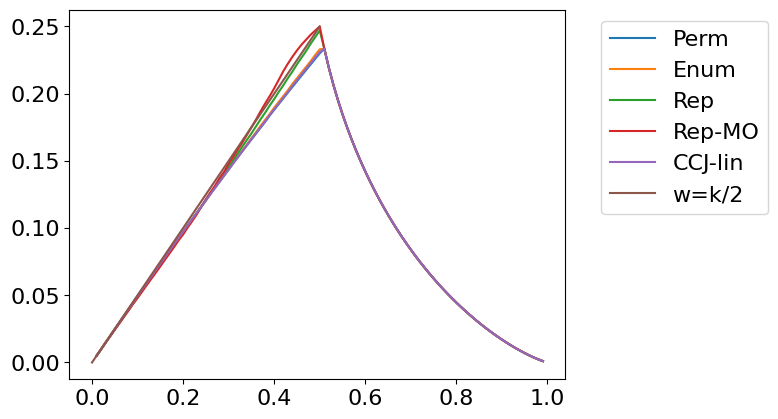

In [23]:
plot("weight", exclude=["CCJ","CCJ-MO","SD-Prange-Reg"])

### Running time of regular-ISD (Section 4.5 "Asymptotic Comparison")

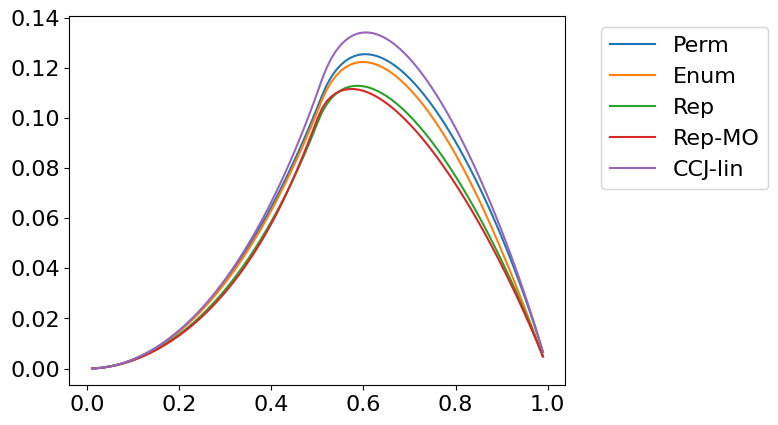

In [24]:
plot("time", exclude=["CCJ","CCJ-MO","CCJ-Lin","SD-Prange-Reg"])

### Running time Rep-MO vs CCJ and Prange-Reg (Section 4.5 "Asymptotic Comparison")

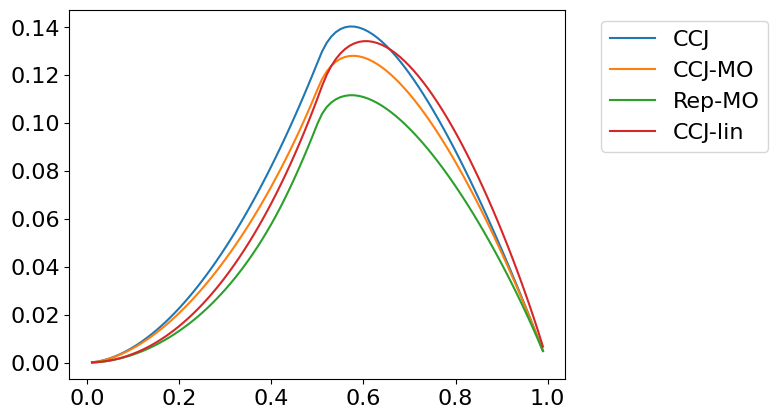

In [25]:
plot("time", exclude=["Rep","Perm","Enum"])

### Worst Case decoding exponents (Section 4.5 Table 2)

In [26]:
def round_up(x,d):
    """
    complexity exponent specific rounding function
    """
    val=int(x*10**d+1)/10**d
    if val<0.0002:
        val=0
    s=str(val)
    if len(s)==1:
        s+="." 
    while len(s)<6:
        s+="0"
    return s

for i in versions:
    worst= max(versions[i]["data"], key = lambda x: x[1][0])
    versions[i]["WC"]=worst
    if len(i)<8:
        print(i,"\t\t&\t",worst[0],"\t&\t",round(worst[1][2],4),"\t&\t",round_up(worst[1][0],4),"\t&\t",round_up(worst[1][1],4),"\\\\")
    else:
        print(i,"\t&\t",worst[0],"\t&\t",round(worst[1][2],4),"\t&\t",round_up(worst[1][0],4),"\t&\t",round_up(worst[1][1],4),"\\\\")

CCJ 		&	 0.57 	&	 0.1659 	&	 0.1404 	&	 0.1404 \\
CCJ-MO 		&	 0.58 	&	 0.1575 	&	 0.1281 	&	 0.1054 \\
Perm 		&	 0.6 	&	 0.1421 	&	 0.1256 	&	 0.0000 \\
Enum 		&	 0.6 	&	 0.1421 	&	 0.1225 	&	 0.0287 \\
Rep 		&	 0.59 	&	 0.1496 	&	 0.1130 	&	 0.0714 \\
Rep-MO 		&	 0.57 	&	 0.1659 	&	 0.1117 	&	 0.0852 \\
CCJ-lin 		&	 0.61 	&	 0.135 	&	 0.1342 	&	 0.0000 \\


### Compute optimal parameters for worst case for approximate exponents (Section 4.5 Table 2)

In [27]:
for i in versions:
    wc = versions[i]["WC"]
    w_in = wc[1][2]
    kp = wc[0]
    time = versions[i]["time"]
    val = time(kp,w_in, params=1)
    if len(val)>2:
        versions[i]["WC_params"]=val[2]
    else:
        versions[i]["WC_params"]=[]

In [28]:
from prettytable import PrettyTable


header=["Algorithm","Rate","Weight","Time","Memory","ell","p","d_x","d_y"]
t = PrettyTable(header)
for i in versions:
    wc = versions[i]["WC"]
    w_in = wc[1][2]
    kp = wc[0]
    par =versions[i]["WC_params"][:-1]
    params = [round(i,7) for i in par]+["-" for _ in range(4-len(par))]
    row=[i,kp,round(w_in,4),round_up(wc[1][0],4),round_up(wc[1][1],4),*params]
    t.add_row(row)

print(t)

+-----------+------+--------+--------+--------+-----------+-----------+-----------+-----------+
| Algorithm | Rate | Weight |  Time  | Memory |    ell    |     p     |    d_x    |    d_y    |
+-----------+------+--------+--------+--------+-----------+-----------+-----------+-----------+
|    CCJ    | 0.57 | 0.1659 | 0.1404 | 0.1404 |     -     |     -     |     -     |     -     |
|   CCJ-MO  | 0.58 | 0.1575 | 0.1281 | 0.1054 |     -     |     -     |     -     |     -     |
|    Perm   | 0.6  | 0.1421 | 0.1256 | 0.0000 |     -     |     -     |     -     |     -     |
|    Enum   | 0.6  | 0.1421 | 0.1225 | 0.0287 | 0.0286751 |  0.007783 |     -     |     -     |
|    Rep    | 0.59 | 0.1496 | 0.1130 | 0.0714 | 0.1757268 | 0.0462968 |  0.008987 |  0.000448 |
|   Rep-MO  | 0.57 | 0.1659 | 0.1117 | 0.0852 | 0.1431215 | 0.0591635 | 0.0140027 | 0.0109514 |
|  CCJ-lin  | 0.61 | 0.135  | 0.1342 | 0.0000 |     -     |     -     |     -     |     -     |
+-----------+------+--------+--------+--

# Effect of Rounding Issues (Section 4.6)

### Plot Precomputed Data from the Dictionary

In [29]:
def get_lists_to_plot(Lround, Lasymp):
    """
    Given the lists stored in versions[i]["rounding"] this function returns the lists containing 
    the relative difference and absolute values of the runtime exponents to be plotted
    """
    L=[]
    for i in range(len(Lround)):
        L.append([Lround[i][0],Lround[i][1],Lasymp[i][1]])
    L_relative_difference=[]
    Lcomp_rounding=[]
    Lcomp_asymptotic = []
    for i in L:
        L_relative_difference.append([i[0],i[1][0]/i[2][0]-1])
        Lcomp_rounding.append([i[0],i[1][0]])
        Lcomp_asymptotic.append([i[0],i[2][0]])
    return L_relative_difference, Lcomp_rounding, Lcomp_asymptotic

def plot_diff(L,label=-1):
    """
    Plots the relative difference 
    """

    x,y=zip(*L)
    if label ==-1:
        plt.scatter(x,y, s=0.4)
    else:
        plt.scatter(x,y, s=0.4, label=label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

def plot_absolute(L,L_r,label=""):
    """
    Plots absolute values of runtime exponents with and without resolving rounding issues
    """
    x,y=zip(*L)
    plt.plot(x,y)
    x,y=zip(*L_r)
    plt.scatter(x,y, s=0.2, label=label)
    # plt.figure(figsize=(5,5))


In [30]:
Lrounding=[]
for i in ["Perm", "Enum", "Rep", "Rep-MO"]:
    Ldiff,Lround,Lasymp = get_lists_to_plot(versions[i]["rounding"]["resolved"],versions[i]["rounding"]["unresolved"])
    Lrounding.append([Ldiff,Lround,Lasymp, i])

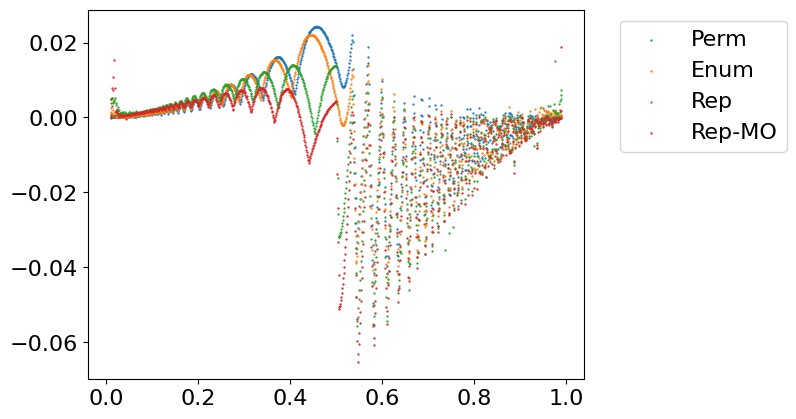

In [31]:
for i in Lrounding:
    plot_diff(i[0],label =i[-1])

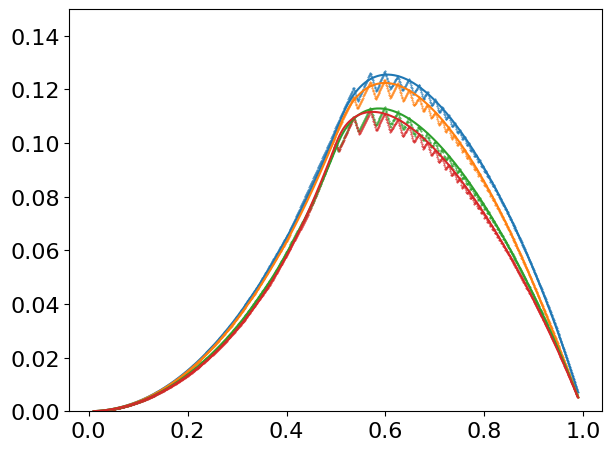

In [32]:
count=1
# plt.subplots(figsize=(16, 3))
for i in Lrounding:
    # plt.subplot(1, 4, count)
    plt.ylim(top=0.15)
    plot_absolute(i[2],i[1],label=i[-1])
    plt.tight_layout()
    count+=1

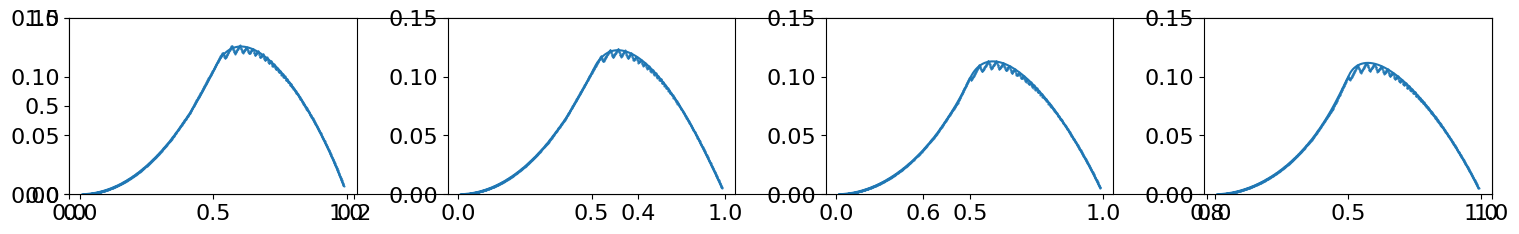

In [33]:
count=1
plt.subplots(figsize=(16, 3))
for i in Lrounding:
    plt.subplot(1, 4, count)
    plt.ylim(top=0.15)
    plot_absolute(i[2],i[1])
    plt.tight_layout()
    count+=1

In [34]:
for i in Lrounding:    
    c1=0
    c0=0
    Lr=i[0]
    if i[-1]=="Rep-MO":
        Lr=i[0][20:-1]
    if i[-1]=="Rep":
        Lr=i[0][0:-18]
    for j in Lr:
        if j[1]<=0.01:
            c1+=1
        if j[1]<=0:
            c0+=1
    res0=c0/len(Lr)
    res1=c1/len(Lr)
    print("For",i[-1],":")
    print("The maximum top-wards deviation from the upperbound is ", max(Lr,key=lambda x: x[1])[1]*100,"% at ", max(Lr,key=lambda x: x[1])[0])
    print("For ", res0*100,"% the asymptotic upperbound ignoring rounding issues is valid")
    print("For ", res1*100,"% the upperbound is valid within a 1% tolerance")



For Perm :
The maximum top-wards deviation from the upperbound is  2.4280407583083363 % at  0.457
For  38.57142857142858 % the asymptotic upperbound ignoring rounding issues is valid
For  80.61224489795919 % the upperbound is valid within a 1% tolerance
For Enum :
The maximum top-wards deviation from the upperbound is  2.212305951658511 % at  0.445
For  40.10204081632653 % the asymptotic upperbound ignoring rounding issues is valid
For  83.87755102040816 % the upperbound is valid within a 1% tolerance
For Rep :
The maximum top-wards deviation from the upperbound is  1.3928567681873671 % at  0.406
For  46.67359667359668 % the asymptotic upperbound ignoring rounding issues is valid
For  89.70893970893971 % the upperbound is valid within a 1% tolerance
For Rep-MO :
The maximum top-wards deviation from the upperbound is  0.788290944000436 % at  0.337
For  55.16162669447341 % the asymptotic upperbound ignoring rounding issues is valid
For  100.0 % the upperbound is valid within a 1% toleran

In [35]:
from bisect import bisect_left  
def Binary_Search(l, x): 
    """ 
    find largest index in l holding an element smaller than x
    """
    i = bisect_left(l, x, key=lambda x:x[0]) 
    if i: 
        return (i-1) 
    else: 
        return -1  
        
def get_wc_weight(ver,k):
    """
    computes the worst case for arbitrary rate k given a list of consecutive rates with corresponding worst case weights
    by linear interpolation for a given version $ver$
    """
    L=versions[ver]["data"]
    if k>0.99:
        k=0.989
    ind=Binary_Search(L,k)
    k1,w1= L[ind][0],L[ind][1][2]
    k2,w2= L[ind+1][0],L[ind+1][1][2]
    a=(w2-w1)/(k2-k1)
    b=w1-a*k1
    return min(a*k+b,uniquness_bound(k))

def adapt_params_r(R, omega,w=10000):
    """
    go to instance with integer blocksize
    """
    b=ceil(1/omega)
    omega_ = 1/b
    n_ = b*w
    k_= round(R*n_)
    R_ = k_/n_
    return R_,omega_

In [36]:
def round_up(x,d):
    """
    complexity exponent specific rounding function
    """
    val=int(x*10**d+1)/10**d
    if val<0.0002:
        val=0
    s=str(val)
    if len(s)==1:
        s+="." 
    while len(s)<6:
        s+="0"
    return s

for i in ["Perm","Enum","Rep","Rep-MO"]:
    worst= max(versions[i]["rounding"]["resolved"][50:-50], key = lambda x: x[1][0])
    if len(i)<8:
        print(i,"\t\t&\t",worst[0],"\t&\t",round(get_wc_weight(i,worst[0]),4),"\t&\t",round_up(worst[1][0],4),"\t&\t",round_up(worst[1][1],4),"\\\\")
    else:
        print(i,"\t&\t",worst[0],"\t&\t",round(worst[1][2],4),"\t&\t",round_up(worst[1][0],4),"\t&\t",round_up(worst[1][1],4),"\\\\")

Perm 		&	 0.599 	&	 0.1428 	&	 0.1268 	&	 0.0000 \\
Enum 		&	 0.599 	&	 0.1428 	&	 0.1237 	&	 0.0310 \\
Rep 		&	 0.599 	&	 0.1428 	&	 0.1134 	&	 0.0682 \\
Rep-MO 		&	 0.569 	&	 0.1668 	&	 0.1119 	&	 0.0711 \\


# Code for recomputation of rounding issue resolved data (currently already loaded via the data.pkl dump)


In [37]:
from math import log2

def compute_rounding_lists(time_r,time,ver,precision=1):
    """
    Computes deviation given function computing time ($time$) and function fixing rounding issues ($time_r$) as well as the version ($ver$) ("Perm", "Enum", ... )
    """

    L_relative_difference=[]
    Lcomp_rounding=[]
    Lcomp_asymptotic=[]


    diff_vals = [];
    omegas=[]
    for R_idx in range(10,990,precision):
    
        R = R_idx/1000;
        w = 10000;
    
        # worst case weight for version $ver$ for rate $R$
        w_wc=get_wc_weight(ver,R)
        
        # Complexity of Perm without fixing the rounding issues
        asymp_comp = time(R,w_wc)[0]#L_perm_wc[R_idx-10][1][0]
        
        time_rounding = time_r(R,w_wc)[0]
    
        L_relative_difference.append([R,time_rounding/asymp_comp - 1])
        Lcomp_rounding.append([R, time_rounding])
        Lcomp_asymptotic.append([R,asymp_comp])
        # if R_idx%100==0:
        #     print(R_idx)
    return L_relative_difference,Lcomp_rounding,Lcomp_asymptotic

### parallel version of above function (used in later computations)

In [38]:
def get_time_theory(ver,R):
    """
    complexity exponent of version $ver$ for rate $R$ including rounding issues 
    """
    Ltheory=versions[ver]["rounding"]["unresolved"]
    
    for i in Ltheory:
        tmp=int(R*1000)
        if tmp==int(i[0]*1000):
            return i[1]

# !!! WARNING !!! Computation will take a while (server with many threads recommended, originally perfromed on cluster with 64 cores (256 threads), computation time was roughly 24-48h) !!! This data is already loaded in the dictionary and above plots were created based on that. Recomputation is not necessary, unless you want to double check or incorporate changes.

# Remember to adapt the ```num_threads``` variable accordingly 

In [39]:
from math import log2
import concurrent.futures

# DONT FORGET TO SET NUMBER OF THREADS
num_threads = 256

def compute_for_one_rate(R_idx):
    """
    computes rounding issues including and resolved complexity exponent for given rate
    """
    R = R_idx/1000;
    w = 10000;

    # worst case weight for version $ver$ for rate $R$
    w_wc=get_wc_weight(ver_thread,R)

    # Complexity without fixing the rounding issues
    # asymp_comp = time_thread(R,w_wc,params=params_thread)
    asymp_comp = get_time_theory(ver_thread, R)

    R_,w_= adapt_params_r(R,w_wc)
    b=int(1/w_)
    time_rounding=[0,0,0]
    # print(R,R_,b)
    for j in range(max(2,b-1),b+2):
        tmp=time_r_thread(R_,1/j,params=params_thread)
        # print(tmp)
        if tmp[0]>time_rounding[0] and tmp[0]!=1:
            time_rounding = tmp+[1/j]
    return R,time_rounding,asymp_comp


def return_two_lists(L):
    """
    splits return values of $compute_for_one_rate$ in two lists
    """
    Lcomp_rounding_full=[]
    Lcomp_asymptotic_full = []
    for i in L:
        Lcomp_rounding_full.append([i[0],i[1]])
        Lcomp_asymptotic_full.append([i[0],i[2]])
    return Lcomp_rounding_full, Lcomp_asymptotic_full
                                     
def compute_rounding_lists_parallel(time_r,time,ver,precision=1,params=0):
    """
    Computes deviation given function computing time ($time$) and function fixing rounding issues ($time_r$) as well as the version ($ver$) ("Perm", "Enum", ... )
    """

    L_relative_difference=[]
    Lcomp_rounding=[]
    Lcomp_asymptotic=[]
    
    global time_thread, time_r_thread, ver_thread, params_thread
    time_thread= time
    time_r_thread = time_r
    ver_thread=ver
    params_thread=params

    diff_vals = [];
    omegas=[]
    data = [i for i in range(10,980,precision)]

    with concurrent.futures.ProcessPoolExecutor(max_workers=num_threads) as executor:
        # Submit the function to the executor for each item in the iterable
        results = list(executor.map(compute_for_one_rate, data))
    return return_two_lists(results)



## Recompute Rounding Issue Resolved Data 

### Solve Rounding Issues for Perm

In [42]:
def perm_with_rounding(R_,omega_, w=10000, params=0):
    """
    computes running time of PERM after resolving rounding issues, for already adapted rate and omega R_, omega_
    """
    k_=round(R_*1/omega_*w)
    eps = (k_-w)/w - floor((k_-w)/w)
    res = [-(omega_ * (1-eps)*log(1-R_+(1+eps)*omega_,2)+ omega_ * eps*log(1-R_+eps*omega_,2))-max(log2(1/omega_)*omega_-(1-R_),0),0]
    
    if params:
        return res+[[]]
    return res
    

In [50]:
Lcomp_rounding_perm_full,Lcomp_asymptotic_perm_full= compute_rounding_lists_parallel(perm_with_rounding,time_perm_rsd_wrapper,"Perm",params=1)
versions["Perm"]["rounding"]={}
versions["Perm"]["rounding"]["resolved"]=Lcomp_rounding_perm_full
versions["Perm"]["rounding"]["unresolved"]=Lcomp_asymptotic_perm_full


### Fix Rounding Issues for Enum

In [44]:
set_vars_enum_r = collections.namedtuple('ENUM_R', 'ell p i N')

def enum_r(f) : return wrap(f, set_vars_enum_r)

v_t = lambda x: (k(x)+x.ell)/max(x.N,0.000000000001)
v_r = lambda x: floor(v_t(x))
wp = lambda x: (k(x)+x.ell-v_r(x)*x.N)/2
wm = lambda x: x.N/2 - wp(x)

sol = lambda x: max(log2(1/w(x))*w(x)-(1-(k(x)+w(x))),0)
prob = lambda x: 2*(binomH(wm(x),x.i)      +log2(1-v_r(x)/b(x))*(wm(x)-x.i)             +log2(v_r(x)/b(x))*x.i
                  + binomH(wp(x),x.p/2-x.i)+log2(1-(v_r(x)+1)/b(x))*(wp(x)-(x.p/2-x.i)) +log2((v_r(x)+1)/b(x))*(x.p/2-x.i))

L1_enum_r = lambda x: binomH(wm(x),x.i)+binomH(wp(x),x.p/2-x.i)+log2(v_r(x))*x.i+log2(v_r(x)+1)*(x.p/2-x.i)

def time_enum_par_r(x):
    """
    complexity exponent of ENUM after resolving rounding issues for given parameter set (ell p i N)
    """
    x=set_vars_enum_r(*x)
    if(b(x)-v_r(x)-1)<1e-10 or x.N<=0:
        return 1000
    if x.p>w(x) or v_r(x)/b(x)<=0 or 1-v_r(x)/b(x)<=0:
        return 1000
    
    L = 2*L1_enum_r(x) - x.ell
    
    return max(L1_enum_r(x),L)+max(-prob(x)-sol(x),0)

def memory_enum_par_r(x):
    """
    memory exponent of ENUM after resolving rounding issues for given parameter set (ell p i N)
    """
    x=set_vars_enum_r(*x)
    return L1_enum_r(x)

constraints_enum_r = [
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : enum_r(lambda x : 1-(x.ell+k([])))},
    { 'type' : 'ineq',   'fun' : enum_r(lambda x : x.N-x.p)},
    { 'type' : 'ineq',   'fun' : enum_r(lambda x : w(x)-x.N)},
    
    # blocks of width at least one
    { 'type' : 'ineq',   'fun' : enum_r(lambda x : b(x)-v_r(x)-1)},
    { 'type' : 'ineq',   'fun' : enum_r(lambda x : v_r(x))},

    { 'type' : 'ineq',   'fun' : enum_r(lambda x : x.p/2-x.i)},
    { 'type' : 'ineq',   'fun' : enum_r(lambda x : wp(x)-(x.p/2-x.i))},
    { 'type' : 'ineq',   'fun' : enum_r(lambda x : wm(x)-x.i)},

]


def time_enum_r(k,w, params=0):
    """
    complexity exponent of ENUM after resolving rounding issues minimized over all parameter sets (ell p i N)
    """
    # outputs time and memory to solve RSD via Enum after resolving rounding issues for already adapted parameters
    return time_opt(k,w,time_enum_par_r,memory_enum_par_r,constraints_enum_r,4,iterations=1000,give_x=0, params=params)


In [ ]:
Lcomp_rounding_enum_full,Lcomp_asymptotic_enum_full= compute_rounding_lists_parallel(time_enum_r,time_enum,"Enum",precision=1,params=1)
versions["Enum"]["rounding"]={}
versions["Enum"]["rounding"]["resolved"]=Lcomp_rounding_enum_full
versions["Enum"]["rounding"]["unresolved"]=Lcomp_asymptotic_enum_full

### Fix Rounding Issues for Rep

In [45]:
set_vars_bj_r = collections.namedtuple('REP_r', 'ell p d1 d2 i di1 di2 N')

def rep_r(f) : return wrap(f, set_vars_bj_r)

def representations_r(ell,p_target,p_addends,block):
    if block<=0: #or ell-p_target<0 or ell-p_target<p_addends-p_target/2:
        return 0
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(block)*(p_addends-p_target/2)
    
v_t = lambda x: (k(x)+x.ell)/max(x.N,0.000000000001)
v_r = lambda x: floor(v_t(x))
wp_bj = lambda x: k(x)+x.ell-v_r(x)*x.N
wm_bj = lambda x: x.N - wp_bj(x)

prob_bj_r = lambda x: binomH(wm_bj(x),x.i)      +log2(1-v_r(x)/b(x))*(wm_bj(x)-x.i)             +log2(v_r(x)/b(x))*x.i + \
                    binomH(wp_bj(x),x.p-x.i)+log2(1-(v_r(x)+1)/b(x))*(wp_bj(x)-(x.p-x.i)) +log2((v_r(x)+1)/b(x))*(x.p-x.i)

# weight on each level (root level is level 0 with weight x.p)
p1_r = lambda x: (x.p-x.i)/2  + x.d1
p2_r = lambda x: p1_r(x) / 2  + x.d2
p3_r = lambda x: p2_r(x) / 2

pi1 = lambda x: x.i/2 + x.di1
pi2 = lambda x: pi1(x) / 2  + x.di2
pi3 = lambda x: pi2(x) / 2


# representations ri from level i to level i-1
r1_r = lambda x: representations_r(wm_bj(x), x.i   , pi1(x), v_r(x)) + representations_r(wp_bj(x), x.p-x.i, p1_r(x), v_r(x)+1)
r2_r = lambda x: representations_r(wm_bj(x), pi1(x), pi2(x), v_r(x)) + representations_r(wp_bj(x), p1_r(x)  , p2_r(x), v_r(x)+1)

# list sizes on each level
L1_r = lambda x: binomH(wm_bj(x)  , pi1(x)) + log2(v_r(x)) * pi1(x) + binomH(wp_bj(x), p1_r(x) ) + log2(v_r(x)+1) * p1_r(x) - r1_r(x)
L2_r = lambda x: binomH(wm_bj(x)  , pi2(x)) + log2(v_r(x)) * pi2(x) + binomH(wp_bj(x), p2_r(x) ) + log2(v_r(x)+1) * p2_r(x) - r2_r(x)
L3_r = lambda x: binomH(wm_bj(x)/2, pi3(x)) + log2(v_r(x)) * pi3(x) + binomH(wp_bj(x)/2,p3_r(x)) + log2(v_r(x)+1) * p3_r(x)

# time Ti to construct lists on level i
T1_r = lambda x: max(2*L1_r(x) - ( x.ell - r1_r(x)  ), L1_r(x))
T2_r = lambda x: max(2*L2_r(x) - ( r1_r(x) - r2_r(x)), L2_r(x))
T3_r = lambda x: max(2*L3_r(x) - ( r2_r(x)          ), L3_r(x))


                      
def time_rep_par_r(x):
    """
    complexity exponent of REP after resolving rounding issues for given parameter set (ell p d1 d2 i di1 di2 N)
    """
    x=set_vars_bj_r(*x)  
    
    # ensuring block length on k+ell part is not larger than overall block length
    if (v_r(x)+1)/b(x)>=1 or v_r(x)<0.99 or x.p<x.i or x.N > w(x):# or wm(x)-x.i<0 or wp(x)-(x.p-x.i)<0 or x.p-x.i<0:
        return 1000

    if wp_bj(x)-p2_r(x)<0 or wp_bj(x)-p1_r(x)-x.d2<0 or wp_bj(x)-(x.p-x.i)-x.d1<0 or wm_bj(x)-pi2(x)<0 or wm_bj(x)-pi1(x)-x.di2<0 or wm_bj(x)-x.i-x.di1<0:
        return 1000
    
    return max(T1_r(x),T2_r(x),T3_r(x))+max(-prob_bj_r(x)-sol(x),0)

def memory_rep_par_r(x):
    """
    memory exponent of REP after resolving rounding issues for given parameter set (ell p d1 d2 i di1 di2 N)
    """
    x=set_vars_bj_r(*x)
    return max(L3_r(x),L2_r(x),L1_r(x))

constraints_rep_r = [
    
    # representation constraints
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : x.ell-r1_r(x))},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : r1_r(x)-r2_r(x))},
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : 1-(x.ell+k([])))},
    # for considering always all blocks in the permutation switch next both lines
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : w(x)-x.N)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : x.N-x.p)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : x.p-x.i)},
    
    # blocks of width at least 1 
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : b(x)-v_r(x)-0.9999)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : v_r(x)-0.9999)},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wp_bj(x)-p2_r(x))},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wp_bj(x)-p1_r(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wp_bj(x)-(x.p-x.i)-x.d1)},

    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wm_bj(x)-pi2(x))},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wm_bj(x)-pi1(x)-x.di2)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wm_bj(x)-x.i-x.di1)},
]

def time_rep_r(k,w, params=0):
    """
    complexity exponent of REP after resolving rounding issues minimized over all parameter sets (ell p d1 d2 i di1 di2 N)
    """
    # outputs time and memory to solve RSD via Rep depth 3 after resolving rounding issues for already adapted parameters
    return time_opt(k,w,time_rep_par_r,memory_rep_par_r,constraints_rep_r,8,iterations=200,give_x=0, params=params)



In [ ]:
Lcomp_rounding_rep_full,Lcomp_asymptotic_rep_full= compute_rounding_lists_parallel(time_rep_r,time_rep,"Rep",precision=1,params=1)
versions["Rep"]["rounding"]={}
versions["Rep"]["rounding"]["resolved"]=Lcomp_rounding_rep_full
versions["Rep"]["rounding"]["unresolved"]=Lcomp_asymptotic_rep_full

### Fix Rounding Issues for Rep-MO

In [46]:
set_vars_bj_r = collections.namedtuple('REP_r', 'ell p d1 d2 i di1 di2 N')

def rep_r(f) : return wrap(f, set_vars_bj_r)

def representations_r(ell,p_target,p_addends,block):
    if block<=0:
        return 0
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(block)*(p_addends-p_target/2)
    
v_r = lambda x: floor((k(x)+x.ell)/max(x.N,0.0000000001))
wp_bj = lambda x: k(x)+x.ell-v_r(x)*x.N
wm_bj = lambda x: x.N - wp_bj(x)

prob_bj_r = lambda x: binomH(wm_bj(x),x.i)      +log2(1-v_r(x)/b(x))*(wm_bj(x)-x.i)             +log2(v_r(x)/b(x))*x.i + \
                    binomH(wp_bj(x),x.p-x.i)+log2(1-(v_r(x)+1)/b(x))*(wp_bj(x)-(x.p-x.i)) +log2((v_r(x)+1)/b(x))*(x.p-x.i)

# weight on each level (root level is level 0 with weight x.p)
p1_r = lambda x: (x.p-x.i)/2  + x.d1
p2_r = lambda x: p1_r(x) / 2  + x.d2
p3_r = lambda x: p2_r(x) / 2

pi1 = lambda x: x.i/2 + x.di1
pi2 = lambda x: pi1(x) / 2  + x.di2
pi3 = lambda x: pi2(x) / 2


# representations ri from level i to level i-1
r1_r = lambda x: representations_r(wm_bj(x), x.i   , pi1(x), v_r(x)) + representations_r(wp_bj(x), x.p-x.i, p1_r(x), v_r(x)+1)
r2_r = lambda x: representations_r(wm_bj(x), pi1(x), pi2(x), v_r(x)) + representations_r(wp_bj(x), p1_r(x)  , p2_r(x), v_r(x)+1)

# list sizes on each level
L1_r = lambda x: binomH(wm_bj(x)  , pi1(x)) + log2(v_r(x)) * pi1(x) + binomH(wp_bj(x), p1_r(x) ) + log2(v_r(x)+1) * p1_r(x) - r1_r(x)
L2_r = lambda x: binomH(wm_bj(x)  , pi2(x)) + log2(v_r(x)) * pi2(x) + binomH(wp_bj(x), p2_r(x) ) + log2(v_r(x)+1) * p2_r(x) - r2_r(x)
L3_r = lambda x: binomH(wm_bj(x)/2, pi3(x)) + log2(v_r(x)) * pi3(x) + binomH(wp_bj(x)/2,p3_r(x)) + log2(v_r(x)+1) * p3_r(x)

# time Ti to construct lists on level i
T1_r = lambda x: max(may_ozerov_near_neighbor_time(L1_r(x),1-k(x)-x.ell,w(x)-x.p), L1_r(x))
T2_r = lambda x: max(2*L2_r(x) - ( r1_r(x) - r2_r(x)), L2_r(x))
T3_r = lambda x: max(2*L3_r(x) - ( r2_r(x)          ), L3_r(x))


                      
def time_rep_par_r(x):
    """
    complexity exponent of REP-MO after resolving rounding issues for given parameter set (ell p d1 d2 i di1 di2 N)
    """
    x=set_vars_bj_r(*x)  
    
    # ensuring block length on k+ell part is not larger than overall block length
    if v_r(x)<0 or v_r(x)/b(x) >=1 or (v_r(x)+1)/b(x)>=1 or v_r(x)<0.99 or x.p<x.i or x.N>w(x):# or wm(x)-x.i<0 or wp(x)-(x.p-x.i)<0 or x.p-x.i<0:
        return 1000

    # if wp_bj(x)-p2_r(x)<0 or wp_bj(x)-p1_r(x)-x.d2<0 or wp_bj(x)-(x.p-x.i)-x.d1<0 or wm_bj(x)-pi2(x)<0 or wm_bj(x)-pi1(x)-x.di2<0 or wm_bj(x)-x.i-x.di1<0:
    #     return 1000
    return max(T1_r(x),T2_r(x),T3_r(x))+max(-prob_bj_r(x)-sol(x),0)

def memory_rep_par_r(x):
    """
    memory exponent of REP-MO after resolving rounding issues for given parameter set (ell p d1 d2 i di1 di2 N)
    """
    x=set_vars_bj_r(*x)
    return max(L3_r(x),L2_r(x),L1_r(x))

constraints_rep_r = [
    
    # representation constraints
    { 'type' : 'eq',   'fun' : rep_r(lambda x : x.ell-r1_r(x))},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : r1_r(x)-r2_r(x))},
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : 1-(x.ell+k([])))},
    # for considering always all blocks in the permutation switch next both lines
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : w(x)-x.N)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : x.N-x.p)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : x.p-x.i)},
    
    # blocks of width at least 1 
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : b(x)-v_r(x)-0.9999)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : v_r(x)-0.9999)},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wp_bj(x)-p2_r(x))},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wp_bj(x)-p1_r(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wp_bj(x)-(x.p-x.i)-x.d1)},

    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wm_bj(x)-pi2(x))},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wm_bj(x)-pi1(x)-x.di2)},
    { 'type' : 'ineq',   'fun' : rep_r(lambda x : wm_bj(x)-x.i-x.di1)},
]

def time_rep_mo_r(k,w, params=0):
    # outputs time and memory to solve RSD via Rep depth 3 after resolving rounding issues for already adapted parameters
    return time_opt(k,w,time_rep_par_r,memory_rep_par_r,constraints_rep_r,8,iterations=350,give_x=0, params=params)



In [ ]:
Lcomp_rounding_repmo_full,Lcomp_asymptotic_repmo_full = compute_rounding_lists_parallel(time_rep_mo_r,time_may_oze,"Rep-MO",precision=1,params=1)

versions["Rep-MO"]["rounding"]={}
versions["Rep-MO"]["rounding"]["resolved"]=Lcomp_rounding_repmo_full
versions["Rep-MO"]["rounding"]["unresolved"]=Lcomp_asymptotic_repmo_full

# Create CSV files containing all optimal values and the parameters leading to them

In [47]:
import csv

def write_csv(L,name):
    f = open(name, 'w')
    writer = csv.writer(f)
    for i in L:
        writer.writerow(i)
    f.close()

### Perm

In [53]:
Lr=versions["Perm"]["rounding"]["resolved"]
La=versions["Perm"]["rounding"]["unresolved"]

Lcsv_rounding=[["Rate","Weight","Time"]]
Lcsv_asymptotic=[["Rate","Weight","Time"]]
for i in range(len(Lr)):
    rate=Lr[i][0]
    weight_a=get_wc_weight("Perm",rate)
    weight_r=Lr[i][1][-1]
    Lcsv_rounding.append([rate,weight_r,Lr[i][1][0]])
    Lcsv_asymptotic.append([rate,weight_a,La[i][1][0]])
write_csv(Lcsv_rounding,"PERM_rounding_resolved.csv")
write_csv(Lcsv_asymptotic,"PERM_rounding_unresolved.csv")

### Enum

In [48]:
Lr=versions["Enum"]["rounding"]["resolved"]
La=versions["Enum"]["rounding"]["unresolved"]

Lcsv_rounding=[["Rate","Weight","Time","ell", "p","i", "N"]]
Lcsv_asymptotic=[["Rate","Weight","Time", "ell", "p", "N"]]
for i in range(len(Lr)):
    rate=Lr[i][0]
    weight_a=get_wc_weight("Enum",rate)
    weight_r=Lr[i][1][-1]
    xa=set_vars_enum(*(np.append(La[i][1][-1],weight_a)))
    xr=set_vars_enum_r(*Lr[i][1][-2])
    Lcsv_rounding.append([rate,weight_r,Lr[i][1][0],xr.ell,xr.p,xr.i,xr.N])
    Lcsv_asymptotic.append([rate,weight_a,La[i][1][0],xa.ell,xa.p,xa.N])
write_csv(Lcsv_rounding,"ENUM_rounding_resolved.csv")
write_csv(Lcsv_asymptotic,"ENUM_rounding_unresolved.csv")

### Rep

In [49]:
Lr=versions["Rep"]["rounding"]["resolved"]
La=versions["Rep"]["rounding"]["unresolved"]

Lcsv_rounding=[["Rate","Weight","Time","ell","p","p^+_x","p^+_y","i","p^-_x","p^-_y", "N"]]
Lcsv_asymptotic=[["Rate","Weight","Time","ell","p","p_x","p_y", "N"]]
for i in range(len(Lr)):
    rate=Lr[i][0]
    weight_a=get_wc_weight("Rep",rate)
    weight_r=Lr[i][1][-1]
    xa=set_vars_bj(*(np.append(La[i][1][-1],weight_a)))
    xr=set_vars_bj_r(*Lr[i][1][-2])
    Lcsv_rounding.append([rate,weight_r,Lr[i][1][0],xr.ell,xr.p,p1_r(xr),p2_r(xr),xr.i,pi1(xr),pi2(xr),xr.N])
    Lcsv_asymptotic.append([rate,weight_a,La[i][1][0],xa.ell,xa.p,p1(xa),p2(xa),xa.N])
write_csv(Lcsv_rounding,"Rep_rounding_resolved.csv")
write_csv(Lcsv_asymptotic,"Rep_rounding_unresolved.csv")

### Rep-MO

In [50]:
Lr=versions["Rep-MO"]["rounding"]["resolved"]
La=versions["Rep-MO"]["rounding"]["unresolved"]

Lcsv_rounding=[["Rate","Weight","Time","ell","p","p^+_x","p^+_y","i","p^-_x","p^-_y", "N"]]
Lcsv_asymptotic=[["Rate","Weight","Time","ell","p","p_x","p_y", "N"]]
for i in range(len(Lr)):
    rate=Lr[i][0]
    weight_a=get_wc_weight("Rep-MO",rate)
    weight_r=Lr[i][1][-1]
    xa=set_vars_repmo(*(np.append(La[i][1][-1],weight_a)))
    xr=set_vars_bj_r(*Lr[i][1][-2])
    Lcsv_rounding.append([rate,weight_r,Lr[i][1][0],xr.ell,xr.p,p1_r(xr),p2_r(xr),xr.i,pi1(xr),pi2(xr),xr.N])
    Lcsv_asymptotic.append([rate,weight_a,La[i][1][0],xa.ell,xa.p,p1(xa),p2(xa),xa.N])
write_csv(Lcsv_rounding,"RepMO_rounding_resolved.csv")
write_csv(Lcsv_asymptotic,"RepMO_rounding_unresolved.csv")

# Dump current dictionary to file

In [ ]:
write_dict(versions)